In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

# Генерация фейковых данных

Ввиду того, что датафрейм с поставками Boeing не очень подходит для данной задачи, было решено сгенерировать собственный датасет.


Рассмотрим следующий сценарий: пусть имеется некоторый видеохостинг, который собирает различную статистику по активности пользователей; в данном случае нас будут интересовать две метрики - ***время (в минутах), потраченное на просмотр видео*** (распределение подчиняется закону **хи-квадрат**) и ***общее количество просмотренных видео за неделю*** (распределение подчиняется закону **пуассона**).


Создадим восемь датасетов (будут наблюдениями за два месяца); при этом *для последней недели специально изменим средние величины, в надежде что наши тесты в дальнейшем будут способны выявить отклонения в распределениях*.

In [ ]:
def create_frame(total=200_000, mean_1=120, mean_2=10):
  """Функция для создания одного фейкового датафрейма"""
  rv_1 = st.chi2.rvs(mean_1, size=total)
  rv_2 = st.poisson.rvs(mean_2, size=total)
  return pd.DataFrame(data={'mins_watched':rv_1, 'videos_watched':rv_2})

In [ ]:
week_data = [create_frame() for _ in range(7)] + [create_frame(mean_1=125, mean_2=13)]

In [ ]:
week_data[0] # Пример созданного датафрейма

,mins_watched,videos_watched
0,113.803710,10
1,121.925622,18
2,119.628002,8
3,110.726748,13
4,114.808179,10
...,...,...
199995,125.000519,9
199996,129.641439,5
199997,129.098735,16
199998,99.233500,11


Выведем сглаженные графики распредления для нескольких недель

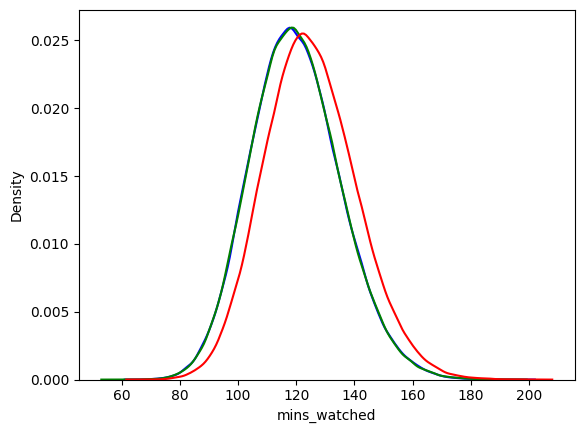

In [ ]:
sns.kdeplot(data=week_data[0], x="mins_watched", color='blue')
sns.kdeplot(data=week_data[3], x="mins_watched", color='green')
sns.kdeplot(data=week_data[7], x="mins_watched", color='red')
plt.show()

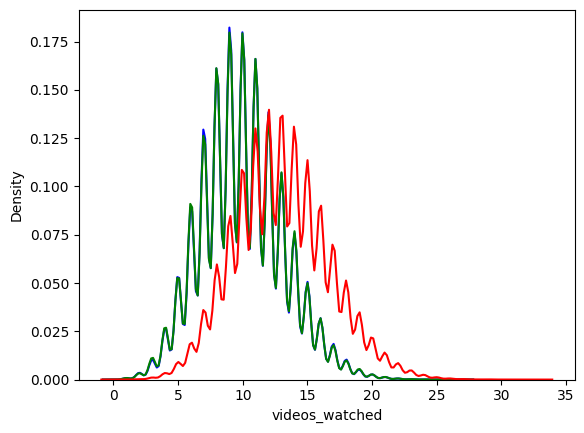

In [ ]:
sns.kdeplot(data=week_data[0], x="videos_watched", color='blue')
sns.kdeplot(data=week_data[3], x="videos_watched", color='green')
sns.kdeplot(data=week_data[7], x="videos_watched", color='red')
plt.show()

Как можно заметить, синий и зеленый графики практически совпадают, тогда как красный значительно от них отличается

# Критерий Колмогорова-Смирнова для проверки на однородность для непрерывного распределения

Сперва проверим на однородность распределения времени просмотра для двух последовательных недель (уровень значимости - 0.05)

In [ ]:
for i in range(7):
  if st.ks_2samp(week_data[i]['mins_watched'], week_data[i+1]['mins_watched']).pvalue > 0.05:
    print(f"Статистически значимых различий между неделями {i+1} и {i+2} не выявлено")
  else:
    print(f"Выявлены статистически значимые различия между неделями {i+1} и {i+2}")

Статистически значимых различий между неделями 1 и 2 не выявлено
Статистически значимых различий между неделями 2 и 3 не выявлено
Статистически значимых различий между неделями 3 и 4 не выявлено
Статистически значимых различий между неделями 4 и 5 не выявлено
Статистически значимых различий между неделями 5 и 6 не выявлено
Статистически значимых различий между неделями 6 и 7 не выявлено
Выявлены статистически значимые различия между неделями 7 и 8


Как и ожидалось, данные по всем неделям, кроме последней, взяты из одного распределения; для дополнительного подтверждения этого расхождения воспользуемся критерием для сопоставления каждой недели с последней

In [ ]:
for i in range(7):
  if st.ks_2samp(week_data[i]['mins_watched'], week_data[7]['mins_watched']).pvalue > 0.05:
    print(f"Статистически значимых различий между неделями {i+1} и 8 не выявлено")
  else:
    print(f"Выявлены статистически значимые различия между неделями {i+1} и 8")

Выявлены статистически значимые различия между неделями 1 и 8
Выявлены статистически значимые различия между неделями 2 и 8
Выявлены статистически значимые различия между неделями 3 и 8
Выявлены статистически значимые различия между неделями 4 и 8
Выявлены статистически значимые различия между неделями 5 и 8
Выявлены статистически значимые различия между неделями 6 и 8
Выявлены статистически значимые различия между неделями 7 и 8


# Расстояние Кульбака-Лейблера и PSI

Сперва реализуем ряд вспомогательных функций

In [ ]:
# Рассчет необходимых величин диапазонов для последующего взятия бинов и рассчета эмпирической функции распределения
range_1 = pd.concat(week_data)['videos_watched'].describe()[['min', 'max']].values
range_2 = pd.concat(week_data)['mins_watched'].describe()[['min', 'max']].values

In [ ]:
def empiric_pdf(data, flag, bins=10):
  """Функция расчета эмпирической функции распределения"""
  if flag == 1:
    return np.histogram(data['videos_watched'], bins, range=range_1)[0] / 200_000
  else:
    return np.histogram(data['mins_watched'], bins, range=range_2)[0] / 200_000

In [ ]:
def KL_dist(a, b):
  """Функция расчета расстояния Кульбака-Лейблера"""
  return np.sum(a * np.where(a * b != 0, np.log(a / b), 0))

In [ ]:
def PSI(a, b):
  """Функция расчета индекса PSI"""
  return KL_dist(a, b) + KL_dist(b, a)

Рассчитаем расстояние Кульбака-Лейблера и PSI для соседних неделей для метрики **mins_watched**

In [ ]:
dists = []
for i in range(7):
  prev_week = empiric_pdf(week_data[i], 0)
  curr_week = empiric_pdf(week_data[i+1], 0)
  dists += [KL_dist(prev_week, curr_week)]
  print(f'Недели {i+1} и {i+2}:\n', "Расстояние Кульбака-Лейблера -", dists[-1], "\n Значение PSI -", PSI(prev_week, curr_week), "\n---")

Недели 1 и 2:
 Расстояние Кульбака-Лейблера - 4.487861924604985e-07 
 Значение PSI - 2.130248345784771e-05 
---
Недели 2 и 3:
 Расстояние Кульбака-Лейблера - 3.960304900193469e-05 
 Значение PSI - 4.9280591478807375e-05 
---
Недели 3 и 4:
 Расстояние Кульбака-Лейблера - -2.3734757837337873e-06 
 Значение PSI - 2.53160224175199e-05 
---
Недели 4 и 5:
 Расстояние Кульбака-Лейблера - 7.542674718031116e-05 
 Значение PSI - 0.0001212129853735071 
---
Недели 5 и 6:
 Расстояние Кульбака-Лейблера - 2.8544980051282848e-05 
 Значение PSI - 5.519847088113555e-05 
---
Недели 6 и 7:
 Расстояние Кульбака-Лейблера - 1.5888428507227464e-05 
 Значение PSI - 3.415204386100698e-05 
---
Недели 7 и 8:
 Расстояние Кульбака-Лейблера - 0.047807525422881615 
 Значение PSI - 0.09500538514707416 
---


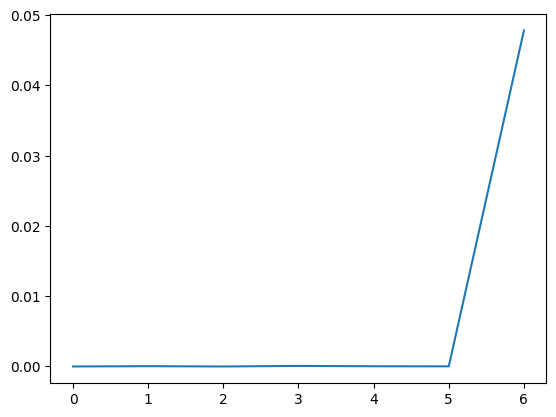

In [ ]:
plt.plot(dists)
plt.show()

Можно легко увидеть, что значение расстояния имеет резкий скачок в последнем случае, что может сигнализировать о неоднородности распределения метрики в последнюю неделю. Чтобы дополнительно убедится в этом, рассчитаем попарное значение индекса PSI с последней неделей.

In [ ]:
last_week = empiric_pdf(week_data[7], 0)
print("Индексы PSI для последней недели по отношению к остальным:")
for i in range(7):
  curr_week = empiric_pdf(week_data[i], 0)
  print(f"Неделя {i+1} - PSI = {PSI(last_week, curr_week)}")

Индексы PSI для последней недели по отношению к остальным:
Неделя 1 - PSI = 0.0974220403801477
Неделя 2 - PSI = 0.097471009176231
Неделя 3 - PSI = 0.09588480407195549
Неделя 4 - PSI = 0.09573559176046455
Неделя 5 - PSI = 0.09563501677319769
Неделя 6 - PSI = 0.09500587335043266
Неделя 7 - PSI = 0.09500538514707416


Хотя и полученные значения лежат в пределах нормы (< 0.1), они значительно отличаются от индексов для других пар (полученных при последовательных попарных сравнениях выше); столь резкая динамика явно свидетельствует о наличие существенных различий в распределении последней недели.

Проделаем то же самое и для метрики **videos_watched**

In [ ]:
dists = []
for i in range(7):
  prev_week = empiric_pdf(week_data[i], 1)
  curr_week = empiric_pdf(week_data[i+1], 1)
  dists += [KL_dist(prev_week, curr_week)]
  print(f'Недели {i} и {i+1}:\n', "Расстояние Кульбака-Лейблера -", dists[-1], "\n Значение PSI -", PSI(prev_week, curr_week), "\n---")

Недели 0 и 1:
 Расстояние Кульбака-Лейблера - 1.7304136098357514e-05 
 Значение PSI - 5.472643599572775e-05 
---
Недели 1 и 2:
 Расстояние Кульбака-Лейблера - 4.373855631486026e-05 
 Значение PSI - 7.778846236573388e-05 
---
Недели 2 и 3:
 Расстояние Кульбака-Лейблера - 7.526905286468874e-05 
 Значение PSI - 0.00015081345626857248 
---
Недели 3 и 4:
 Расстояние Кульбака-Лейблера - 1.748219644234585e-05 
 Значение PSI - 4.470741963082659e-05 
---
Недели 4 и 5:
 Расстояние Кульбака-Лейблера - 1.8317043026377282e-05 
 Значение PSI - 1.6693732806025683e-05 
---
Недели 5 и 6:
 Расстояние Кульбака-Лейблера - 1.8510486239504617e-05 
 Значение PSI - 3.713029409815687e-05 
---
Недели 6 и 7:
 Расстояние Кульбака-Лейблера - 0.3426776156369754 
 Значение PSI - 0.7171811083474847 
---


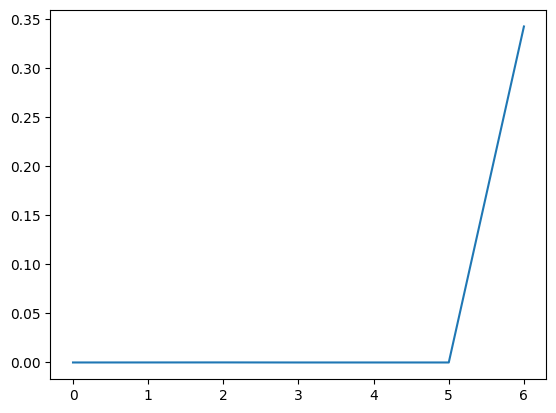

In [ ]:
plt.plot(dists)
plt.show()

In [ ]:
last_week = empiric_pdf(week_data[7], 1)
print("Индексы PSI для последней недели по отношению к остальным:")
for i in range(7):
  curr_week = empiric_pdf(week_data[i], 1)
  print(f"Неделя {i+1} - PSI = {PSI(last_week, curr_week)}")

Индексы PSI для последней недели по отношению к остальным:
Неделя 1 - PSI = 0.7241536255394624
Неделя 2 - PSI = 0.7222726282606695
Неделя 3 - PSI = 0.7281891426795699
Неделя 4 - PSI = 0.7260606833779926
Неделя 5 - PSI = 0.7241638679255642
Неделя 6 - PSI = 0.7247314254254255
Неделя 7 - PSI = 0.7171811083474847


И снова мы получили существенный скачок в величине расстояния для последней недели; при этом попарный расчет индексов PSI показывает наличие критических различий в распределении метрики 8 недели по отношению к остальным

# Простой DQ

Напоследок, попробует выявить различия при помощи визульного отслеживания динамики изменения некоторых характеристик метрик. Для нашей задачи для этого хорошо подходят среднее значение метрики за неделю и медина за неделю

Сперва рассмотрим метрику **videos_watched**

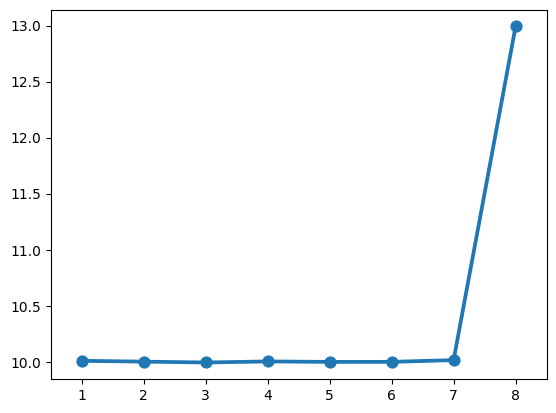

In [ ]:
sns.pointplot(x=[i for i in range(1, 9)], y=[week_data[i]['videos_watched'].mean() for i in range(8)])
plt.show()

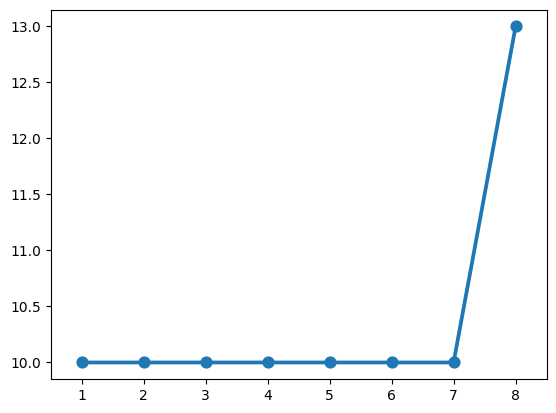

In [ ]:
sns.pointplot(x=[i for i in range(1, 9)], y=[week_data[i]['videos_watched'].median() for i in range(8)])
plt.show()

Нетрудно заметить резкий и существенный скачок последней недели - явный сигнал о значимом изменении в распределении

Теперь рассмотрим метрику **mins_watched**

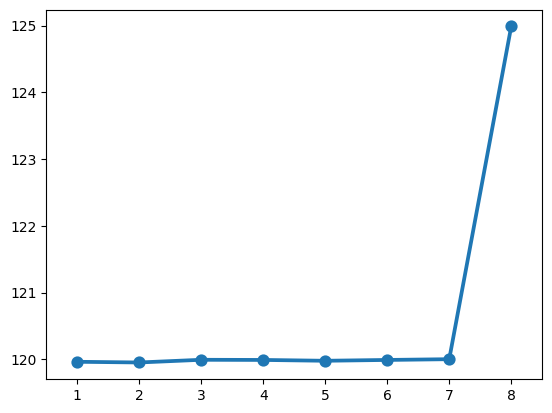

In [ ]:
sns.pointplot(x=[i for i in range(1, 9)], y=[week_data[i]['mins_watched'].mean() for i in range(8)])
plt.show()

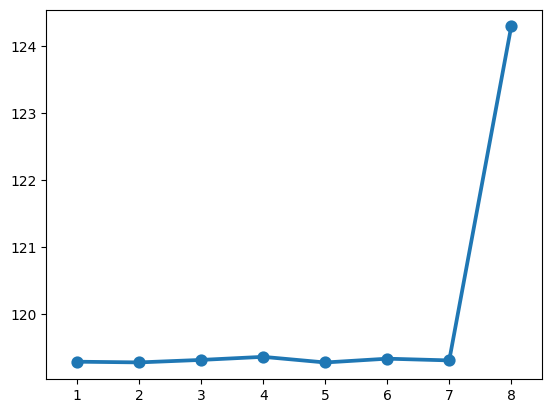

In [ ]:
sns.pointplot(x=[i for i in range(1, 9)], y=[week_data[i]['mins_watched'].median() for i in range(8)])
plt.show()

И снова - резкий и существенный скачок в конце, что намекает на неоднородность распределения в последнюю неделю